In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Change according to your project directory path
NLP_PATH = "gdrive/MyDrive/NLP_Project/"

In [ ]:
import os
import sys
from datetime import datetime
import pickle
import gc


import os
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from nltk.corpus import stopwords
import nltk

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

import torch
# from torchtext import data

SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import torchtext
import re
from torch.utils.data import DataLoader,TensorDataset

%matplotlib inline  

nltk.download('punkt')
nltk.download('stopwords')

# import spacy
# tokenizer = spacy.load('en_core_web_sm')
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from gensim.models.keyedvectors import KeyedVectors

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!python -m spacy download en_core_web_sm

2023-05-04 19:38:55.392161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Data retrieval

We get the complete data containing the numerical data added in the previous ipynb file.

In [ ]:
df_hf_complete =pd.read_csv(NLP_PATH+'Data/data_complete.csv')

In [ ]:
df_hf_complete['Text']=df_hf_complete['Title']+' '+df_hf_complete['BodyMarkdown']

In [ ]:
df_hf_complete

,Unnamed: 0.1,Unnamed: 0,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,...,verbs_title,verbs_body,count_verbs_body,count_verbs_title,adj_title,adj_body,count_adj_body,count_adj_title,nb_exclamations_body,Text
0,0,0,7430637,2011-09-15 12:15:49,552264,2010-12-23 10:25:04,85,6,Android ArrayList in Application Class,I'm trying to pass arrayLists over the applica...,...,[],"[""'m"", 'trying', 'pass', 'filling', 'i', 'get'...",19,0,['android'],"['public', 'application', 'private', 'new', 'p...",39,1,0,Android ArrayList in Application Class I'm try...
1,1,1,1655489,2009-10-31 20:13:52,106658,2009-05-13 21:04:16,1367,82,Differences between NSTableView and NSCollecti...,I'm trying to decide which path to take for de...,...,[],"[""'m"", 'trying', 'decide', 'take', 'developing...",47,0,[],"['snow', 'leopard', 'first', 'obvious', 'multi...",20,0,0,Differences between NSTableView and NSCollecti...
2,2,2,10263717,2012-04-21 22:48:03,1203134,2012-02-10 23:10:33,11,0,CellEditorListener will not detect when a cell...,I am working on my CapStone project to graduat...,...,"['detect', 'has', 'been', 'edited']","['am', 'working', 'graduate', 'have', 'run', '...",157,4,[],"['few', 'point-of-sales', 'fictitious', 'total...",160,0,4,CellEditorListener will not detect when a cell...
3,3,3,9460144,2012-02-27 04:39:48,936178,2011-09-09 05:36:06,1,0,"Is it possible to put an ""if statement"" inside...","IN RUBY,\r\nfor example, if you wanted to prin...",...,"['is', 'put']","['wanted', 'print', 'put', 'clean', 'write', '...",16,2,['possible'],"['first', 'last', 'little', 'i', 'while/for', ...",8,1,0,"Is it possible to put an ""if statement"" inside..."
4,4,4,7482593,2011-09-20 08:59:59,218450,2009-11-25 09:49:30,570,11,Is is time to use Entity Framework 4.0 now?,We are working on a quite big project written ...,...,"['is', 'is', 'use']","['are', 'working', 'written', 'contains', 'are...",59,3,[],"['big', 'stored', 'first', 'known', 'horrible'...",25,0,0,Is is time to use Entity Framework 4.0 now? We...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157098,157098,22438,8510589,2011-12-14 19:38:27,562566,2011-01-04 12:55:15,3878,200,Java openGL and GTK based apps screwing up C++...,I'm developing a engine + a game built on top ...,...,"['based', 'screwing']","[""'m"", 'developing', '+', 'built', ""'m"", 'runn...",66,2,[],"['i', 'bizarre', 'i', 'other', 'user', 'i', 'l...",44,0,1,Java openGL and GTK based apps screwing up C++...
157099,157099,22439,1999946,2010-01-04 14:44:21,243253,2010-01-04 14:44:21,1,0,Whats are the differences between clear case a...,Whats are the differences between clear case a...,...,['are'],['are'],1,1,"['clear', 'virtual', 'safe']","['clear', 'virtual', 'safe']",3,3,0,Whats are the differences between clear case a...
157100,157100,22440,7971898,2011-11-01 19:39:25,496619,2010-11-03 23:58:38,1,2,Can't see any content on wiki.rubyonrails.org,Am I the only one who doesn't see any content ...,...,['see'],"['am', 'i', 'does', 'see', 'visiting', '[', '[']",7,1,[],"['only', 'wiki.rubyonrails.org', '//wiki.rubyo...",3,0,0,Can't see any content on wiki.rubyonrails.org ...
157101,157101,22441,11519857,2012-07-17 09:39:56,1157346,2012-01-18 23:03:27,517,38,newcommand and math environement,So I've created a latex `command` using `newco...,...,[],"[""'ve"", 'created', 'using', 'is', '\\twopartde...",16,0,[],"['i', 'latex', 'll', '\\\\', 'i', 'f', '=', '\...",10,0,0,newcommand and math environement So I've creat...


In [ ]:
#numerical data

num_data = df_hf_complete[['ReputationAtPostCreation','OwnerUndeletedAnswerCountAtPostTime','TotalTags','count_nouns_body','count_nouns_title','count_verbs_body',
                  'count_verbs_title','count_adj_body','count_adj_title','nb_exclamations_body']]
num_data

,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,TotalTags,count_nouns_body,count_nouns_title,count_verbs_body,count_verbs_title,count_adj_body,count_adj_title,nb_exclamations_body
0,85,6,4,133,3,19,0,39,1,0
1,1367,82,4,59,3,47,0,20,0,0
2,11,0,4,544,2,157,4,160,0,4
3,1,0,1,14,3,16,2,8,1,0
4,570,11,1,74,3,59,3,25,0,0
...,...,...,...,...,...,...,...,...,...,...
157098,3878,200,2,130,5,66,2,44,0,1
157099,1,0,3,5,4,1,1,3,3,0
157100,1,2,2,15,2,7,1,3,0,0
157101,517,38,1,23,3,16,0,10,0,0


## Text embedding

In [ ]:
# Environment variables
EMBED_DIM = 50
# Reduce MAX_SEQ_LENGTH to save RAM
MAX_SEQ_LENGTH = 100
# Reduce TRAIN_SAMPLE_LIMIT to save RAM
TRAIN_SAMPLE_LIMIT=20000


In [ ]:
def SO_get_vec(reduced_vectors=None,reduced_tokens=None,token=None,idx=None):
  assert token is None or idx is None
  vocab_len = len(reduced_tokens)

  if token is not None:
    token = token.lower()
    if token in reduced_vectors.keys():
      return (torch.clone(reduced_vectors[token][0]),reduced_vectors[token][1])
    else:
      return (torch.zeros((50)),-1)

  if idx is not None:
    if idx == -1 or idx >= vocab_len:
      return (torch.zeros((50)),-1)
    else:
      token = reduced_tokens[idx]
      return (torch.clone(reduced_vectors[token][0]),reduced_vectors[token][1])


In [ ]:
def gen_text_emb(so_aug=False,df_hf_complete=None,train_sample_limit=7500,embed_dim=50,max_seq_length=100):
  #Tokenize First
  tokenizer = get_tokenizer("spacy",'en')

  textblocks = df_hf_complete['Text']

  if train_sample_limit!=None and train_sample_limit > 0:
      N = min(train_sample_limit,len(textblocks))
      textblocks = textblocks[0:N]
  else:
      N = len(textblocks)
  X_lan  = torch.zeros((N,max_seq_length,embed_dim))

  # Import GloVe embeddings
  GLOVE_NAME = '6B'
  glove_vec = GloVe(name=GLOVE_NAME, dim=embed_dim)

  if so_aug:
    # Import StackOverflow embeddings
    so_vec = KeyedVectors.load_word2vec_format(NLP_PATH+"Data/SO_vectors_200.bin", binary=True)
    pca = PCA(n_components=embed_dim)
    numpy_reduced = pca.fit_transform(so_vec.vectors)

    reduced_vectors = dict()
    reduced_tokens = so_vec.index_to_key.copy()
    for idx, numpy_vector in enumerate(numpy_reduced):
       reduced_vectors[reduced_tokens[idx]] = [torch.from_numpy(numpy_vector),idx]
    vocab_size = len(reduced_tokens)

    # Add Glove embbedings for tokens that are not present in Stack Overflow embbedings. 
    for token_idx, token in enumerate(glove_vec.itos):
      token = token.lower()
      if token_idx % 10000 == 0:
        print(str(token_idx))
      #Check if the token already exists in Stack Overflow.
      if token in reduced_vectors.keys():
        continue
      else:
        reduced_vectors[token] = [torch.clone(glove_vec.get_vecs_by_tokens(token)),vocab_size]
        vocab_size += 1
        reduced_tokens.append(token)

    for block_idx,block in enumerate(textblocks):
      if block_idx % 1000 == 0:
        print(block_idx)

      sentence_enc = torch.zeros(max_seq_length,embed_dim)

      tokenblock = tokenizer(block)
      tokenblock = tokenblock[0:min(len(tokenblock),max_seq_length)]
      for token_idx, token in enumerate(tokenblock):
        sentence_enc[token_idx] = SO_get_vec(reduced_vectors=reduced_vectors,reduced_tokens=reduced_tokens,token=token)[0]
      X_lan[block_idx] = sentence_enc
  
  else:
    for block_idx,block in enumerate(textblocks):
      if block_idx % 1000 == 0:
        print(block_idx)
        
      sentence_enc = torch.zeros(max_seq_length,embed_dim)

      tokenblock = tokenizer(block)
      tokenblock = tokenblock[0:min(len(tokenblock),max_seq_length)]
      for token_idx, token in enumerate(tokenblock):
        sentence_enc[token_idx] = torch.clone(glove_vec.get_vecs_by_tokens(token))
      X_lan[block_idx] = sentence_enc
  
  return X_lan,N

## Train/Test split

In [ ]:
X_lan,N = gen_text_emb(so_aug=False,df_hf_complete=df_hf_complete,train_sample_limit=TRAIN_SAMPLE_LIMIT,embed_dim=EMBED_DIM,max_seq_length=MAX_SEQ_LENGTH)

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [ ]:
#X_meta = df[features][0:N]
y = df_hf_complete['y'][0:N]
#X_meta = df[features]
# y = df['y']

# X_lan = wEncodings[0:N]

X_indices = list(range(N))

X_train_indices, X_test_indices, y_train, y_test = train_test_split(X_indices, y, stratify=y, test_size=0.2, random_state=1)
#Use Indices Instead, for X, thank me later

X_lan_train = X_lan[X_train_indices]
X_lan_test = X_lan[X_test_indices]

X_lan_train[:1]

tensor([[[-0.3768, -0.2835,  0.3639,  ...,  0.5029,  0.4600,  0.6341],
         [ 0.3304,  0.2500, -0.6087,  ..., -0.5070, -0.0273, -0.5329],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [ ]:
# add pytorch model here

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
X_lan_train_tensor = torch.tensor(X_lan_train).type(torch.FloatTensor).to(device)
X_lan_test_tensor = torch.tensor(X_lan_test).type(torch.FloatTensor).to(device)
y_train_tensor = torch.tensor(y_train.values).type(torch.FloatTensor).to(device)
y_test_tensor = torch.tensor(y_test.values).type(torch.FloatTensor).to(device)

<ipython-input-169-6229802f1924>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_lan_train_tensor = torch.tensor(X_lan_train).type(torch.FloatTensor).to(device)
<ipython-input-169-6229802f1924>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_lan_test_tensor = torch.tensor(X_lan_test).type(torch.FloatTensor).to(device)


In [ ]:
# X_lan_train_tensor.shape, y_train_tensor.shape
train_dataset = TensorDataset(X_lan_train_tensor,y_train_tensor)
test_dataset = TensorDataset(X_lan_test_tensor,y_test_tensor)

## Model (lstm or gru) without additionnal numeric features

In [ ]:
HIDDEN_LAYER = EMBED_DIM

class QuestionClassifier(nn.Module):
    def __init__(self, num_features, hidden_layer,rnn_type="lstm"):
        super(QuestionClassifier, self).__init__()
        #Encoder
        self.rnn_type = rnn_type
        if self.rnn_type == "lstm":
          self.rnn = nn.LSTM(num_features, hidden_layer, batch_first = True)
        elif self.rnn_type == "gru":
          self.rnn = nn.GRU(num_features, hidden_layer, batch_first = True)
        self.label = nn.Linear(hidden_layer, 1)

    def forward(self, embedded_sentence, apply_sigmoid=False):
      if self.rnn_type == "lstm":
        self.out, (self.h,self.c) = self.rnn(embedded_sentence)
      
      elif self.rnn_type == "gru":
        self.out, self.h = self.rnn(embedded_sentence)

      tag_space = self.label(self.h)
      tag_score = F.sigmoid(tag_space)
      return tag_score

model = QuestionClassifier(EMBED_DIM, HIDDEN_LAYER,rnn_type="lstm").to(device)
print(model)

QuestionClassifier(
  (rnn): LSTM(50, 50, batch_first=True, dropout=0.3)
  (label): Linear(in_features=50, out_features=1, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Train

In [ ]:
BATCH_SIZE = 64
print(f"Specifying Batch Size as {BATCH_SIZE}")

Specifying Batch Size as 64


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
REPORT_EVERY_N_BATCHES = 100
eps = 1e-7

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)[0]
#         print(pred)
#         print(pred.shape, y.view(-1,1).shape)
#         print(pred.dtype, y.view(-1,1).dtype)
        
        loss = loss_fn(pred, y.view(-1,1))
        # break

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % REPORT_EVERY_N_BATCHES == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    tp, tn, fp, fn = 0,0,0,0
    precision, recall = 0,0
    f1 = 0

    with torch.no_grad():
        print_ex=True
        for X, y in dataloader:
            pred = model(X)[0]
#             print("pred")
            # print(pred.shape)
#             print(pred)
            # print(pred.mean(axis=1) > 0 )
            # break
            # print("predict?")
            # print((pred > 0))
            # break
            y_pred = (pred > 0.5).to(torch.int)
            y_true = y.view(-1,1)
#             print(y_pred.shape)
#             print(y_true.shape)
            # break
#             print('"MEAN":')
#             print(pred.mean(axis=1))
#             break
#             y_pred = (pred.mean(axis=1) >= np.log(0.5)).to(torch.int)
            if print_ex:
#                 print(pred, y_pred, y_true)
                print_ex = False

            test_loss += loss_fn(pred, y.view(-1,1)).item()


            # tp = (y_true * y_pred).sum().to(torch.float32)
            ttp = (y_true * y_pred).sum().to(torch.float32)
            tp += ttp
            ttn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
            tn += ttn
            fp += ((1 - y_true) * y_pred).sum().to(torch.float32)
            fn += (y_true * (1 - y_pred)).sum().to(torch.float32)

            correct += (ttp+ttn).type(torch.float).sum().item()
            # print("y_pred")
            # print(y_pred)
            # print("y_true")
            # print(y_true)
            

    test_loss /= num_batches
    correct /= size

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision+recall+eps)


    print(f"Test Error: \n Accuracy: {(100*correct):>0.3f}%, Avg loss: {test_loss:>8f} \n")
    # print(y_pred, y_true)
    # print(tp, tn, fp, fn, correct, size)
    # print(tp, correct, size)
    acc = 100*correct
    # print(tp, tn, acc, correct)
    return (acc, test_loss, precision, recall, f1)

In [ ]:
now = datetime.now()

# dd/mm/YY H:M:S
current_time = now.strftime("%d-%m-%H-%M")


def save_performance(epoch):

    torch.save(model, f'output/models/lan_model_{current_time}_ep_{epoch}.pth')
    torch.save(model.state_dict(), f'output/models/lan_model_state_{current_time}_ep_{epoch}.pth')

    with open(f'output/performances/acc_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_accuracies, filehandler)
    with open(f'output/performances/loss_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_losses, filehandler)
    with open(f'output/performances/precisions_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_precisions, filehandler)
    with open(f'output/performances/recalls_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_recalls, filehandler)
    with open(f'output/performances/f1s_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_f1s, filehandler)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!mkdir output
!mkdir output/models
!mkdir output/performances

mkdir: cannot create directory ‘output’: File exists
mkdir: cannot create directory ‘output/models’: File exists
mkdir: cannot create directory ‘output/performances’: File exists


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
EPOCHS = 500#1000
SAVE_EVERY_N_EPOCHS = 50
LEARNING_RATE = 1e-5

loss_fn = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

epoch_accuracies = []
epoch_losses = []
epoch_precisions = []
epoch_recalls = []
epoch_f1s = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    epoch_acc, epoch_avg_loss, epoch_precision, epoch_recall, epoch_f1 = test_loop(test_dataloader, model, loss_fn)
    epoch_accuracies.append(epoch_acc)
    epoch_losses.append(epoch_avg_loss)
    epoch_precisions.append(epoch_precision)
    epoch_recalls.append(epoch_recall)
    epoch_f1s.append(epoch_f1)
    
    if (t+1)%SAVE_EVERY_N_EPOCHS==0:
        save_performance(t+1)
        gc.collect()
        if device == "cuda":
          torch.cuda.empty_cache()

print("Done!")

Epoch 1
-------------------------------
loss: 0.694917  [    0/16000]
loss: 0.697111  [ 6400/16000]
loss: 0.690472  [12800/16000]
Test Error: 
 Accuracy: 49.425%, Avg loss: 0.693077 

Epoch 2
-------------------------------
loss: 0.693297  [    0/16000]
loss: 0.720999  [ 6400/16000]
loss: 0.689665  [12800/16000]
Test Error: 
 Accuracy: 49.525%, Avg loss: 0.690241 

Epoch 3
-------------------------------
loss: 0.672087  [    0/16000]
loss: 0.690113  [ 6400/16000]
loss: 0.698104  [12800/16000]
Test Error: 
 Accuracy: 49.600%, Avg loss: 0.687715 

Epoch 4
-------------------------------
loss: 0.689074  [    0/16000]
loss: 0.669300  [ 6400/16000]
loss: 0.700799  [12800/16000]
Test Error: 
 Accuracy: 49.625%, Avg loss: 0.685050 

Epoch 5
-------------------------------
loss: 0.681450  [    0/16000]
loss: 0.689176  [ 6400/16000]
loss: 0.681986  [12800/16000]
Test Error: 
 Accuracy: 49.725%, Avg loss: 0.682790 

Epoch 6
-------------------------------
loss: 0.687018  [    0/16000]
loss: 0.71

<Figure size 640x480 with 0 Axes>

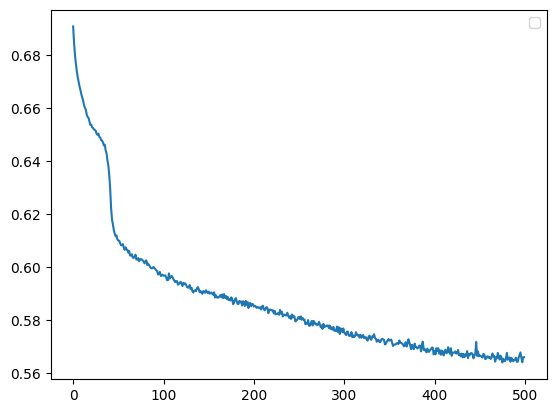

In [ ]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure()

plt.plot([i for i in range(EPOCHS)],epoch_losses)

plt.legend()
plt.show()

## Model (lstm or gru) with additionnal numeric features

In [ ]:
# Classifier including numeric features
## hidden_size

HIDDEN_LAYER = EMBED_DIM

class QuestionClassifier(nn.Module):
    def __init__(self, num_features, hidden_layer,rnn_type="lstm"):
        super(QuestionClassifier, self).__init__()
        #Encoder
        self.rnn_type = rnn_type
        if self.rnn_type == "lstm":
          self.rnn = nn.LSTM(num_features, hidden_layer, batch_first = True)
        elif self.rnn_type == "gru":
          self.rnn = nn.GRU(num_features, hidden_layer, batch_first = True)
        self.label = nn.Linear(hidden_layer, 1)


    def forward(self, embedded_sentence, apply_sigmoid=False):
      if self.rnn_type == "lstm":
        self.out, (self.h,self.c) = self.rnn(embedded_sentence)
      
      elif self.rnn_type == "gru":
        self.out, self.h = self.rnn(embedded_sentence)

      tag_space = self.label(self.h)
      tag_score = F.sigmoid(tag_space)
      #print(tag_space)
      #print(tag_score)
      #return tag_score

      x = torch.cat([tag_score, torch.tensor(num_data.values)], dim=1) #concatenation output with num torch features
      x = F.relu(self.dense1(x))
      x = torch.sigmoid(self.dense2(x))
      return x

model = QuestionClassifier(EMBED_DIM, HIDDEN_LAYER,rnn_type="gru").to(device)
print(model)

QuestionClassifier(
  (rnn): GRU(50, 50, batch_first=True)
  (label): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
BATCH_SIZE = 64
print(f"Specifying Batch Size as {BATCH_SIZE}")

Specifying Batch Size as 64


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
REPORT_EVERY_N_BATCHES = 100
eps = 1e-7

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)[0]
#         print(pred)
#         print(pred.shape, y.view(-1,1).shape)
#         print(pred.dtype, y.view(-1,1).dtype)
        
        loss = loss_fn(pred, y.view(-1,1))
        # break

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % REPORT_EVERY_N_BATCHES == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    tp, tn, fp, fn = 0,0,0,0
    precision, recall = 0,0
    f1 = 0

    with torch.no_grad():
        print_ex=True
        for X, y in dataloader:
            pred = model(X)[0]
#             print("pred")
            # print(pred.shape)
#             print(pred)
            # print(pred.mean(axis=1) > 0 )
            # break
            # print("predict?")
            # print((pred > 0))
            # break
            y_pred = (pred > 0.5).to(torch.int)
            y_true = y.view(-1,1)
#             print(y_pred.shape)
#             print(y_true.shape)
            # break
#             print('"MEAN":')
#             print(pred.mean(axis=1))
#             break
#             y_pred = (pred.mean(axis=1) >= np.log(0.5)).to(torch.int)
            if print_ex:
#                 print(pred, y_pred, y_true)
                print_ex = False

            test_loss += loss_fn(pred, y.view(-1,1)).item()


            # tp = (y_true * y_pred).sum().to(torch.float32)
            ttp = (y_true * y_pred).sum().to(torch.float32)
            tp += ttp
            ttn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
            tn += ttn
            fp += ((1 - y_true) * y_pred).sum().to(torch.float32)
            fn += (y_true * (1 - y_pred)).sum().to(torch.float32)

            correct += (ttp+ttn).type(torch.float).sum().item()
            # print("y_pred")
            # print(y_pred)
            # print("y_true")
            # print(y_true)
            

    test_loss /= num_batches
    correct /= size

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision+recall+eps)


    print(f"Test Error: \n Accuracy: {(100*correct):>0.3f}%, Avg loss: {test_loss:>8f} \n")
    # print(y_pred, y_true)
    # print(tp, tn, fp, fn, correct, size)
    # print(tp, correct, size)
    acc = 100*correct
    # print(tp, tn, acc, correct)
    return (acc, test_loss, precision, recall, f1)

In [ ]:
now = datetime.now()

# dd/mm/YY H:M:S
current_time = now.strftime("%d-%m-%H-%M")


def save_performance(epoch):

    torch.save(model, f'output/models/lan_model_{current_time}_ep_{epoch}.pth')
    torch.save(model.state_dict(), f'output/models/lan_model_state_{current_time}_ep_{epoch}.pth')

    with open(f'output/performances/acc_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_accuracies, filehandler)
    with open(f'output/performances/loss_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_losses, filehandler)
    with open(f'output/performances/precisions_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_precisions, filehandler)
    with open(f'output/performances/recalls_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_recalls, filehandler)
    with open(f'output/performances/f1s_{current_time}_ep_{epoch}.pkl', 'wb') as filehandler:
        pickle.dump(epoch_f1s, filehandler)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)

With StackOverflow embedding

In [ ]:
EPOCHS = 500#1000
SAVE_EVERY_N_EPOCHS = 50
LEARNING_RATE = 1e-5

loss_fn = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

epoch_accuracies = []
epoch_losses = []
epoch_precisions = []
epoch_recalls = []
epoch_f1s = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    epoch_acc, epoch_avg_loss, epoch_precision, epoch_recall, epoch_f1 = test_loop(test_dataloader, model, loss_fn)
    epoch_accuracies.append(epoch_acc)
    epoch_losses.append(epoch_avg_loss)
    epoch_precisions.append(epoch_precision)
    epoch_recalls.append(epoch_recall)
    epoch_f1s.append(epoch_f1)
    
    if (t+1)%SAVE_EVERY_N_EPOCHS==0:
        save_performance(t+1)
        gc.collect()
        if device == "cuda":
          torch.cuda.empty_cache()

print("Done!")

Epoch 1
-------------------------------
loss: 0.678957  [    0/16000]
loss: 0.665361  [ 6400/16000]
loss: 0.673562  [12800/16000]
Test Error: 
 Accuracy: 62.650%, Avg loss: 0.673810 

Epoch 2
-------------------------------
loss: 0.678328  [    0/16000]
loss: 0.691100  [ 6400/16000]
loss: 0.685934  [12800/16000]
Test Error: 
 Accuracy: 62.775%, Avg loss: 0.671651 

Epoch 3
-------------------------------
loss: 0.650567  [    0/16000]
loss: 0.658169  [ 6400/16000]
loss: 0.661720  [12800/16000]
Test Error: 
 Accuracy: 62.800%, Avg loss: 0.670171 

Epoch 4
-------------------------------
loss: 0.680436  [    0/16000]
loss: 0.687908  [ 6400/16000]
loss: 0.690606  [12800/16000]
Test Error: 
 Accuracy: 62.850%, Avg loss: 0.667892 

Epoch 5
-------------------------------
loss: 0.639717  [    0/16000]
loss: 0.650153  [ 6400/16000]
loss: 0.658447  [12800/16000]
Test Error: 
 Accuracy: 62.825%, Avg loss: 0.666415 

Epoch 6
-------------------------------
loss: 0.667872  [    0/16000]
loss: 0.69

<Figure size 640x480 with 0 Axes>

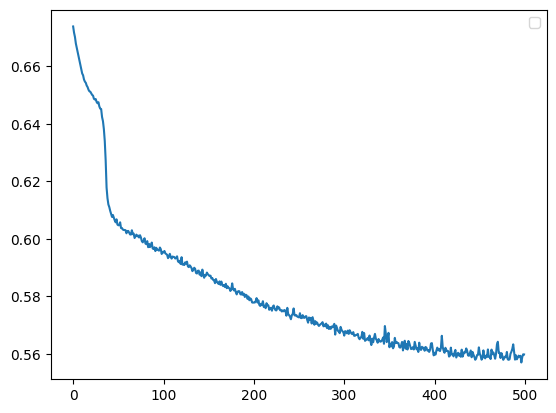

In [ ]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure()

plt.plot([i for i in range(EPOCHS)],epoch_losses)

plt.legend()
plt.show()

Without StackOverflow Embedding

In [ ]:
EPOCHS = 500#1000
SAVE_EVERY_N_EPOCHS = 50
LEARNING_RATE = 1e-5

loss_fn = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

epoch_accuracies = []
epoch_losses = []
epoch_precisions = []
epoch_recalls = []
epoch_f1s = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    epoch_acc, epoch_avg_loss, epoch_precision, epoch_recall, epoch_f1 = test_loop(test_dataloader, model, loss_fn)
    epoch_accuracies.append(epoch_acc)
    epoch_losses.append(epoch_avg_loss)
    epoch_precisions.append(epoch_precision)
    epoch_recalls.append(epoch_recall)
    epoch_f1s.append(epoch_f1)
    
    if (t+1)%SAVE_EVERY_N_EPOCHS==0:
        save_performance(t+1)
        gc.collect()
        if device == "cuda":
          torch.cuda.empty_cache()

print("Done!")

Epoch 1
-------------------------------
loss: 0.689811  [    0/16000]
loss: 0.694619  [ 6400/16000]
loss: 0.691671  [12800/16000]
Test Error: 
 Accuracy: 61.650%, Avg loss: 0.687565 

Epoch 2
-------------------------------
loss: 0.690460  [    0/16000]
loss: 0.686659  [ 6400/16000]
loss: 0.683671  [12800/16000]
Test Error: 
 Accuracy: 62.475%, Avg loss: 0.685210 

Epoch 3
-------------------------------
loss: 0.686745  [    0/16000]
loss: 0.683365  [ 6400/16000]
loss: 0.687749  [12800/16000]
Test Error: 
 Accuracy: 62.775%, Avg loss: 0.682989 

Epoch 4
-------------------------------
loss: 0.683426  [    0/16000]
loss: 0.670246  [ 6400/16000]
loss: 0.685948  [12800/16000]
Test Error: 
 Accuracy: 62.800%, Avg loss: 0.681093 

Epoch 5
-------------------------------
loss: 0.697730  [    0/16000]
loss: 0.676894  [ 6400/16000]
loss: 0.681278  [12800/16000]
Test Error: 
 Accuracy: 62.800%, Avg loss: 0.679034 

Epoch 6
-------------------------------
loss: 0.696162  [    0/16000]
loss: 0.67

<Figure size 640x480 with 0 Axes>

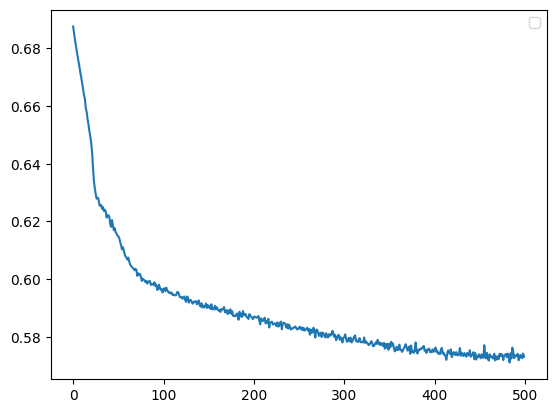

In [ ]:
import matplotlib.pyplot as plt

plt.clf()
plt.figure()

plt.plot([i for i in range(EPOCHS)],epoch_losses)

plt.legend()
plt.show()